In [1]:
# Auto PEP8 Code
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Enable Plots in Jupyter Notebook
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import os
from typing import Union, Iterator

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
# Variables
folder_name = "shapes"

In [4]:
# Create HoG Features
def generate_hog_features(folder_name: str) -> Union[list, list]:
    print("Generating training set feature vectors ...")

    img_path = f"input/{folder_name}"

    x_train = []
    y_train = []

    # Get all the image folder paths
    img_paths = os.listdir(img_path)
    for path in img_paths:

        # Get lists containing names of all images for training set
        main_path = f"{img_path}/{path}"
        all_images = os.listdir(main_path)

        # Run HoGs on training set
        for image in all_images:

            # Get image
            image_path = f"{main_path}/{image}"

            # Read image
            image = cv2.imread(image_path)

            # Apply Gaussian Blur
            image = cv2.GaussianBlur(image, (5, 5), cv2.BORDER_DEFAULT)

            # Resize to 64 x 128 - HoGs requires 1:2 ratio
            image = cv2.resize(image, (64, 128))

            # Calculate HOG descriptor for each image
            hog_desc = feature.hog(
                image,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                transform_sqrt=True,
                block_norm="L2",
            )

            # Add images and labels
            x_train.append(hog_desc)
            y_train.append(path)

    print("Finished generating training set feature vectors ...")
    return x_train, y_train


x_train, y_train = generate_hog_features(folder_name)

Generating training set feature vectors ...
Finished generating training set feature vectors ...


In [5]:
### Report code - View all feature vectors
print("All X feature vectors:", x_train)
print("All Y feature vectors:", y_train)

All X feature vectors: [array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0.

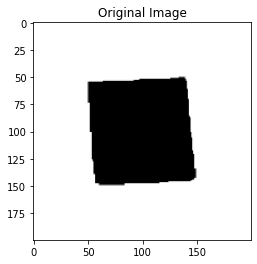

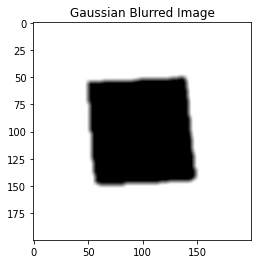

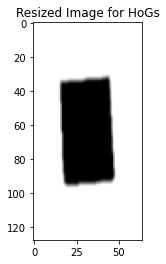

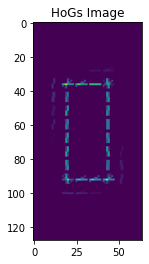

Single X Feature Vector:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+0

<IPython.core.display.Javascript object>

In [8]:
### Report code - View HoG Features (single image)

# Add image path here
img = cv2.imread("./input/shapes/square/0.png")

plt.imshow(img)
plt.title("Original Image")
plt.show()

# Apply Gaussian Blur
img = cv2.GaussianBlur(img, (5, 5), cv2.BORDER_DEFAULT)

plt.imshow(img)
plt.title("Gaussian Blurred Image")
plt.show()

# Resize to 64 x 128 - HoGs requires 1:2 ratio
img = cv2.resize(img, (64, 128))

plt.imshow(img)
plt.title("Resized Image for HoGs")
plt.show()

# Calculate HOG descriptor for each image
(hg_desc, hg_image) = feature.hog(
    img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm="L2",
    visualize=True,
    transform_sqrt=True,
)
plt.imshow(hg_image)
plt.title("HoGs Image")
plt.show()

with np.printoptions(threshold=np.inf):
    print("Single X Feature Vector: ", hg_desc)

In [6]:
# Create the SVM model
def generate_svm(x_train: list, y_train: list) -> LinearSVC:
    print("Training SVM model ...")

    svm_model = LinearSVC(random_state=42, tol=1e-5)
    svm_model.fit(x_train, y_train)

    print("Finished training SVM model ...")
    return svm_model


svm_model = generate_svm(x_train, y_train)

Training SVM model ...
Finished training SVM model ...


In [7]:
# Sliding window for test set
def sliding_window(
    image: np.ndarray, step_sz: int, window_sz: tuple
) -> Iterator[tuple]:
    for y in range(0, image.shape[0], step_sz):
        for x in range(0, image.shape[1], step_sz):
            yield (x, y, image[y : y + window_sz[1], x : x + window_sz[0]])


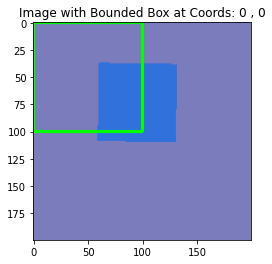

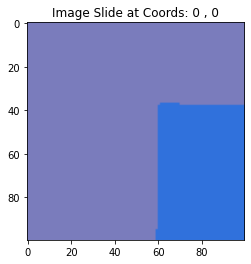

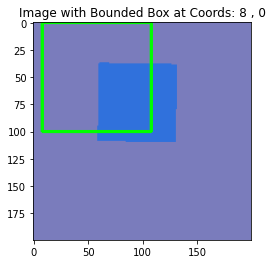

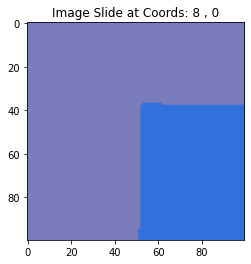

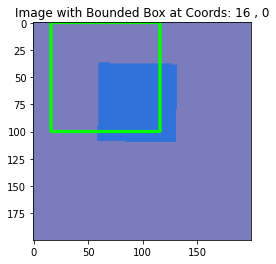

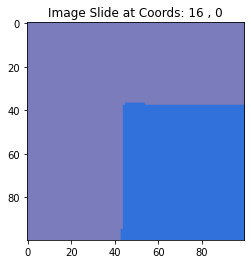

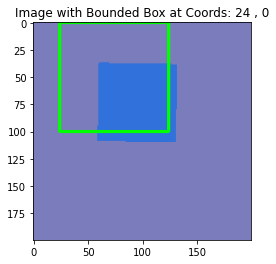

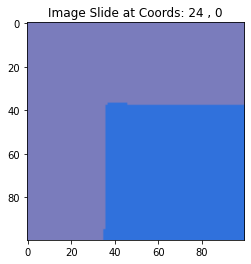

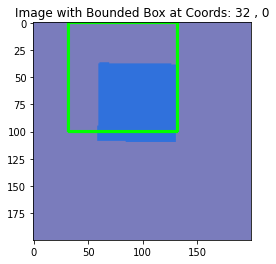

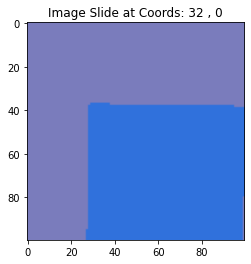

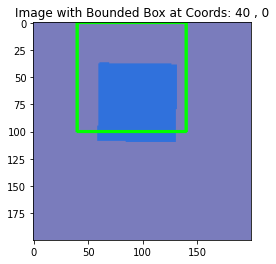

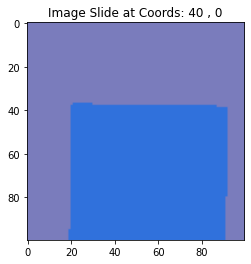

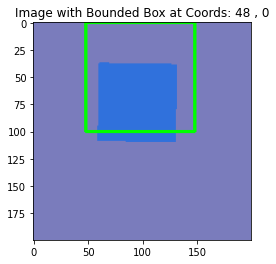

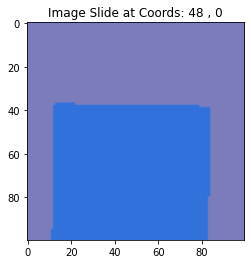

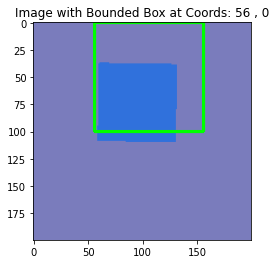

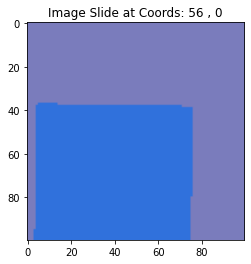

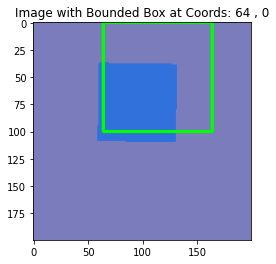

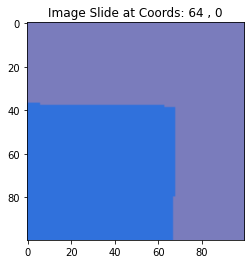

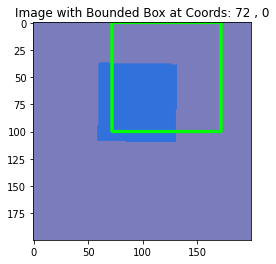

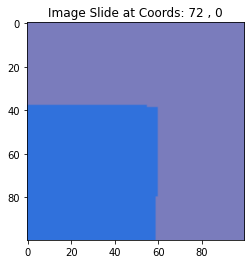

<IPython.core.display.Javascript object>

In [11]:
### Report code - View Sliding Window (single image)
# Add image path here
img = cv2.imread("./test_images/shapes/square-35.png")

window_sz = (100, 100)
win_width, win_height = window_sz

i = 0
for x, y, image_slide in sliding_window(img, 8, window_sz):
    # Draw bounding box on image
    img_ = img.copy()
    image_box = cv2.rectangle(
        img_, (x, y), (x + win_width, y + win_height), (0, 255, 0), 2
    )
    plt.imshow(image_box)
    plt.title(f"Image with Bounded Box at Coords: {x} , {y}")
    plt.show()

    plt.imshow(image_slide)
    plt.title(f"Image Slide at Coords: {x} , {y}")
    plt.show()

    i += 1
    # Stop at 10 iterations
    if i == 10:
        break

In [8]:
# Perform image pyramid on test set
def pyramid(image: np.ndarray, scale=2.5, minSize=(5, 5)) -> Iterator[np.ndarray]:
    yield image

    while True:
        # Calculate new dimensions and resize image
        width = int(image.shape[1] / scale)
        height = int(image.shape[0] / scale)
        dim = (width, height)

        image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

        # Break when smaller than minimum size
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

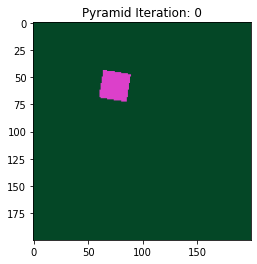

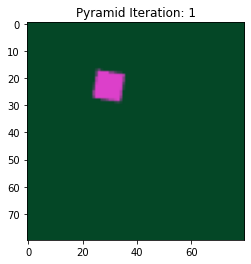

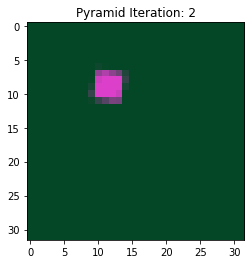

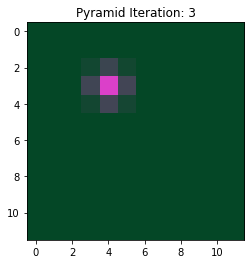

In [9]:
### Report code - View Pyramid (single image)
# Add image path here
img = cv2.imread("./test_images/shapes/square-1.png")

# loop over the image pyramid
for (i, resized) in enumerate(pyramid(img)):
    # show the resized image
    plt.imshow(resized)
    plt.title(f"Pyramid Iteration: {i}")
    plt.show()

In [10]:
# Algo for test set with sliding window
def test_set_algo(
    image: np.ndarray, svm_model: LinearSVC, step_sz=8, window_sz=(100, 100)
) -> Union[str, str, np.ndarray, np.ndarray]:
    x_test = []
    y_test = []
    image_meta = []
    image = cv2.resize(image, (200, 200))
    win_width, win_height = window_sz

    for (i, image_pyr) in enumerate(pyramid(image)):
        for x, y, window in sliding_window(
            image_pyr, step_sz=step_sz, window_sz=window_sz
        ):
            # Ignore if window does not match shape
            if window.shape[0] != win_height or window.shape[1] != win_width:
                continue

            # Resize to HoG size - 1:2 ratio
            window = cv2.resize(window, (64, 128))

            # Apply Gaussian Blur
            window = cv2.GaussianBlur(window, (5, 5), cv2.BORDER_DEFAULT)

            (hog_desc, hog_image) = feature.hog(
                window,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm="L2",
                visualize=True,
                transform_sqrt=True,
            )

            x_pred = hog_desc.reshape(1, -1)
            y_pred = svm_model.predict(x_pred)[0]

            x_test.append(x_pred)
            y_test.append(y_pred)
            image_meta.append((x, y, hog_image))

    # Get idx of best fitting point
    des_func = list(map(svm_model.decision_function, x_test))
    des_max = max(des_func)

    print("Best Decision: ", str(des_max))

    des_func_idx = des_func.index(des_max)

    x_test = x_test[des_func_idx]
    y_test = y_test[des_func_idx]

    # Get best fitting sliding window data
    x, y, hog_image = image_meta[des_func_idx]

    # Draw bounding box on image
    image = cv2.rectangle(
        image, (x, y), (x + win_width, y + win_height), (0, 255, 0), 2
    )

    return x_test, y_test, image, hog_image


test_img = cv2.imread("./test_images/shapes/square-0.png")
x_test, y_test, image, hog_image = test_set_algo(test_img, svm_model)

Best Decision:  [0.2325164]


In [11]:
# Algo for test set without sliding window
def test_set_algo_raw(
    image: np.ndarray, svm_model: LinearSVC
) -> Union[str, str, np.ndarray, np.ndarray]:
    
    image = cv2.resize(image, (200, 200))

    # Resize to HoG size - 1:2 ratio
    image = cv2.resize(image, (64, 128))

    # Apply Gaussian Blur
    image = cv2.GaussianBlur(image, (5, 5), cv2.BORDER_DEFAULT)

    (hog_desc, hog_image) = feature.hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2",
        visualize=True,
        transform_sqrt=True,
    )

    x_test = hog_desc.reshape(1, -1)
    y_test = svm_model.predict(x_test)[0]

    return x_test, y_test, image, hog_image

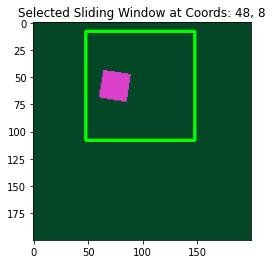

X Test Feature Vector:  [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0. 

<IPython.core.display.Javascript object>

In [15]:
### Report code - Generate test set features
# Add image path here
img = cv2.imread("./test_images/shapes/square-1.png")
# svm_model calculated above

# This is a modified version of the above function such that you can
# view the data
def test_set_algo_report(
    image: np.ndarray, svm_model: LinearSVC, step_sz=8, window_sz=(100, 100)
) -> Union[str, np.ndarray, np.ndarray]:
    x_test = []
    y_test = []
    image_meta = []
    image = cv2.resize(image, (200, 200))
    win_width, win_height = window_sz

    for (i, image_pyr) in enumerate(pyramid(image)):
        for x, y, window in sliding_window(
            image_pyr, step_sz=step_sz, window_sz=window_sz
        ):
            # Ignore if window does not match shape
            if window.shape[0] != win_height or window.shape[1] != win_width:
                continue

            # Resize to HoG size - 1:2 ratio
            window = cv2.resize(window, (64, 128))

            # Apply Gaussian Blur
            window = cv2.GaussianBlur(window, (5, 5), cv2.BORDER_DEFAULT)

            (hog_desc, hog_image) = feature.hog(
                window,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm="L2",
                visualize=True,
                transform_sqrt=True,
            )

            x_pred = hog_desc.reshape(1, -1)
            y_pred = svm_model.predict(x_pred)[0]

            x_test.append(x_pred)
            y_test.append(y_pred)
            image_meta.append((x, y, hog_image))

    # Get idx of best fitting point
    des_func = list(map(svm_model.decision_function, x_test))
    des_max = max(des_func)

    des_func_idx = des_func.index(des_max)
    label = y_test[des_func_idx]

    x_test = x_test[des_func_idx]
    y_test = y_test[des_func_idx]

    # Get best fitting sliding window data
    x, y, hog_image = image_meta[des_func_idx]

    # Draw bounding box on image
    image = cv2.rectangle(
        image, (x, y), (x + win_width, y + win_height), (0, 255, 0), 2
    )

    ### Report Code
    plt.clf()
    plt.imshow(image)
    plt.title(f"Selected Sliding Window at Coords: {x}, {y}")
    plt.show()

    with np.printoptions(threshold=np.inf):
        print("X Test Feature Vector: ", x_test)
        print("Y Test Feature Vector: ", y_test)
    print("Best Decision: ", str(des_max))

    return


test_set_algo_report(img, svm_model)

In [21]:
# Run the SVM model
def run_svm(folder_name: str, svm_model: LinearSVC, window_pyr = True) -> None:
    # Run SVM model on test images
    print("Running SVM model on testing set ...")

    x_test_all = []
    y_test_all = []

    img_path = f"test_images/{folder_name}"
    img_paths = os.listdir(img_path)

    output_path = f"outputs/"

    # loop over the test dataset folders
    for (i, img) in enumerate(img_paths):
        # File pathing
        img = f"{img_path}/{img}"
        image = cv2.imread(img)

        # Run HoGs algorithim, sliding window and pyramid
        if window_pyr:
            x_test, y_test, image, hog_image = test_set_algo(image, svm_model)
        else:
            x_test, y_test, image, hog_image = test_set_algo_raw(image, svm_model)
            
        # Collect all features
        x_test_all.append(x_test)
        y_test_all.append(y_test)

        # Print predictions
        img_name = img.split("/")[-1][:-4]

        print("Actual:", img_name)
        print("Predicted:", y_test)

        # Rescale HoG image
        hog_image = hog_image.astype("float64")

        # Add text to image
        actual_text = f"Actual: {img_name}"
        predicted_text = f"Predicted: {y_test}"

        cv2.putText(
            image,
            predicted_text,
            (10, 40),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2,
        )
        cv2.putText(
            image, actual_text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2
        )

        # Write output images to output folder
        cv2.imwrite(f"{output_path}hog_{i}.jpg", hog_image * 255.0)
        cv2.imwrite(f"{output_path}pred_{i}.jpg", image)

    return x_test_all, y_test_all


test_folder = "test_cfn"
run_svm(test_folder, svm_model)

Running SVM model on testing set ...
Best Decision:  [-0.99731746]
Actual: blank5
Predicted: blank
Best Decision:  [-0.99731746]
Actual: blank6
Predicted: blank
Best Decision:  [-0.99731746]
Actual: blank7
Predicted: blank
Best Decision:  [0.9458059]
Actual: square-1
Predicted: square
Best Decision:  [0.5459469]
Actual: square-2
Predicted: square
Best Decision:  [1.88799332]
Actual: square-3
Predicted: square


([array([[0., 0., 0., ..., 0., 0., 0.]]),
  array([[0., 0., 0., ..., 0., 0., 0.]]),
  array([[0., 0., 0., ..., 0., 0., 0.]]),
  array([[0., 0., 0., ..., 0., 0., 0.]]),
  array([[0., 0., 0., ..., 0., 0., 0.]]),
  array([[0., 0., 0., ..., 0., 0., 0.]])],
 ['blank', 'blank', 'blank', 'square', 'square', 'square'])

In [13]:
# Create confusion matrix
def generate_cfn_mtx(y_true: list, y_pred: list, title: "str", labels: list) -> None:
    class_names = ["Negative", "Positive"]
    graph_text = [["TN", "FP"], ["FN", "TP"]]

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot
    plt.clf()
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.summer)

    plt.title(f"SVM Confusion Matrix - {title}")
    plt.ylabel("True")
    plt.xlabel("Predicted")

    # Ticks
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(graph_text[i][j]) + " = " + str(cm[i][j]))
    plt.show()

In [14]:
# Print model accuracy and classification
def view_model_acc(y_true: list, y_pred: list) -> None:
    # Accuracy of Model
    acc = accuracy_score(y_true, y_pred)
    print(f"\nModel Accuracy: {acc}\n")

    # Classification Report
    print(
        "\nClassification Report: \n",
        classification_report(y_true, y_pred),
    )

In [ ]:
### Report code - Generate confusion matrix on training  set
# Training Set pt. 1
# (didn't test this since input set is huge) - have fun Tyrone ;)
labels = ["square", "blank"]

train_folder = "shapes"
test_folder = "train_cfn"

x_train, y_train = generate_hog_features(train_folder)
svm_model = generate_svm(x_train, y_train)
x_test, y_test = run_svm(test_folder, svm_model, window_pyr=False)

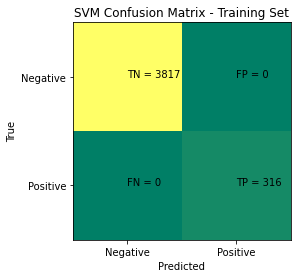

In [23]:
### Report code - Generate confusion matrix on training set
# Training Set pt. 2
generate_cfn_mtx(y_train, y_test, "Training Set", labels)
view_model_acc(y_train, y_test)

In [ ]:
### Report code - Generate confusion matrix on test set
# Testing Set pt. 1
labels = ["square", "blank"]
train_folder = "shapes"
test_folder = "test_cfn"

x_train, y_train = generate_hog_features(train_folder)
svm_model = generate_svm(x_train, y_train)
x_test, y_test = run_svm(test_folder, svm_model)

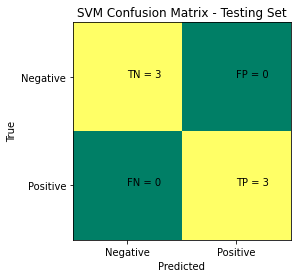


Model Accuracy: 1.0


Classification Report: 
               precision    recall  f1-score   support

       blank       1.00      1.00      1.00         3
      square       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



<IPython.core.display.Javascript object>

In [45]:
### Report code - Generate confusion matrix on test set
# Testing Set pt. 2
# Get labels from test folder based on file name
img_path = f"test_images/{test_folder}"
img_paths = os.listdir(img_path)
y_test_true = ["blank" if "blank" in file_name else "square" for file_name in img_paths]

generate_cfn_mtx(y_test_true, y_test, "Testing Set", labels)
view_model_acc(y_test_true, y_test)

In [46]:
# Bringing it all together now ...
train_folder = "shapes"
test_folder = "test_cfn"

x_train, y_train = generate_hog_features(train_folder)

svm_model = generate_svm(x_train, y_train)

x_test, y_test = run_svm(test_folder, svm_model)

Generating training set feature vectors ...
Finished generating training set feature vectors ...
Training SVM model ...
Finished training SVM model ...
Running SVM model on testing set ...
Best Decision:  [-0.99731746]
Actual: blank5
Predicted: blank
Best Decision:  [-0.99731746]
Actual: blank6
Predicted: blank
Best Decision:  [-0.99731746]
Actual: blank7
Predicted: blank
Best Decision:  [0.9458059]
Actual: square-1
Predicted: square
Best Decision:  [0.5459469]
Actual: square-2
Predicted: square
Best Decision:  [1.88799332]
Actual: square-3
Predicted: square


<IPython.core.display.Javascript object>

In [47]:
# Weights
with np.printoptions(threshold=np.inf):
    print(svm_model.coef_[0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.05387391e-03  1.03238424e-03
  1.13838187e-03  1.56774108e-03  6.51607837e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.77763204e-03  1.75786325e-03  5.30437008e-03  2.45608223e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.17920214e-02  3.14857960e-03  3.47185265e-03
  4.78131825e-03  5.76850179e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.71050543e-20  8.38325845e-04
  8.29002945e-04  2.50152474e-03  1.41155127e-02  0.00000000e+00
  0.00000000e+00  0.00000

<IPython.core.display.Javascript object>

In [93]:
# Generate weights heat map
import plotly.express as px
weights = svm_model.coef_
weights = weights.reshape((15, 252))

x_labels=[f"Block {i}" for i in range(1, 9)]
y_labels=[f"Row {i}" for i in range(1, 16)]

fig = px.imshow(weights,y=y_labels, title="SVM Weight Heat Map (HoG)")
fig.update_xaxes(
    ticktext=x_labels,
    tickvals=[(i * 36) for i in range(1, 8)] + [251],
    title_text= "Feature Vector Block (36 x 1 Features)",
    ticks="outside"
)
fig.update_yaxes(title_text='Feature Vectors')

fig.update_traces(hovertemplate="x: %{x} <br>y: %{y} <br>Weight: %{z}")
fig.show()